In [ ]:
%load_ext autoreload
%load_ext autotime

time: 154 µs (started: 2024-12-12 22:28:18 -08:00)


In [2]:
import os
import sys
import time
import warnings
from bokeh.io import output_notebook

# Add WisIO to the path
sys.path.append(os.path.abspath("../"))

# Filter warnings
warnings.filterwarnings('ignore')

# Set the notebook to display Bokeh plots
output_notebook()

Loading BokehJS ...

time: 624 ms (started: 2024-12-12 22:28:19 -08:00)


In [3]:
analyzer = "dftracer"

run_dir = f".wisio/{analyzer}/{int(time.time())}"
bottleneck_dir = f"{run_dir}/bottlenecks"
checkpoint_dir = f"{run_dir}/checkpoints"

cluster = "external"
cluster_restart_on_connect = True
cluster_scheduler_address = "tcp://127.0.0.1:46423"

checkpoint = False
exclude_characteristics = ['node_count', 'app_count', 'proc_count', 'file_count']
logical_view_types = False
percentile = 0.95
time_granularity = 1e6
trace_path = "/p/lustre3/iopp/dftracer-traces-lfs/v1.0.5-develop/corona/cm1/APP/node-1/v1/RAW/*.pfw.gz"

app_metrics = [
    'intensity',
    'io_compute_per',
    # 'io_bw',
    # 'io_time_norm',
    # 'io_time_per',
    'ops',
    'time_norm',
    'time_per',
    # 'u_checkpoint_io_time',
    # 'u_io_time_per',
    # 'u_read_io_time',
]
dataloader_metrics = [
    'intensity',
    # 'io_bw',
    # 'io_time_norm',
    # 'io_time_per',
    'ops',
    # 'read_bw',
    'time_norm',
    'time_per',
    # 'write_bw',
]
posix_metrics = [
    'intensity',
    'data_bw',
    'data_time_norm',
    'data_time_per',
    'ops',
    # 'read_bw',
    'time_norm',
    'time_per',
    # 'write_bw',
]

app_view_types = ['proc_name', 'time_range']
dataloader_view_types = ['proc_name', 'time_range']
posix_view_types = ['proc_name', 'time_range']

time_view_type = 'time_range'
unoverlapped_posix_only = False

output_compact = False
output_group_behavior = False
output_max_bottlenecks = 1
output_root_only = True


time: 1.54 ms (started: 2024-12-12 22:28:20 -08:00)


In [5]:
# Parameters
analyzer = "dftracer"
checkpoint = True
checkpoint_dir = "/p/lustre3/iopp/wisio-checkpoints/dftracer-unet3d-dlio-v100-node-1-v1-time"
logical_view_types = False
# metrics = ["time"]
output_max_bottlenecks = 1
output_root_only = False
run_dir = ".wisio/dftracer-unet3d-dlio-v100-node-1-v1-time"
percentile = 0.9
# time_granularity = 4000000.0
trace_path = "/p/lustre3/iopp/dftracer-traces-lfs/v1.0.5-develop/corona/unet3d/dlio-v100/node-1/v1/RAW/*.pfw.gz"

app_view_types = ["proc_name", "time_range"]
dataloader_view_types = ["proc_name", "time_range"]
posix_view_types = ["proc_name", "time_range"]

time: 882 µs (started: 2024-12-12 22:28:54 -08:00)


In [6]:
from distributed import Client
from hydra import compose, initialize
from hydra.core.hydra_config import HydraConfig
from hydra.utils import instantiate
from wisio.cluster import ExternalCluster
from wisio.config import init_hydra_config_store
from wisio.utils.file_utils import ensure_dir

ensure_dir(run_dir)

with initialize(version_base=None, config_path=None):
    init_hydra_config_store()
    cfg = compose(
        config_name="config",
        overrides=[
            f"+analyzer={analyzer}",
            f"analyzer.bottleneck_dir={bottleneck_dir}",
            f"analyzer.checkpoint={checkpoint}",
            f"analyzer.checkpoint_dir={checkpoint_dir}",
            f"analyzer.time_granularity={time_granularity}",
            # f"cluster={cluster}",
            # f"cluster.restart_on_connect={cluster_restart_on_connect}",
            # f"cluster.scheduler_address={cluster_scheduler_address}",
            "cluster=external",
            "cluster.scheduler_address=tcp://127.0.0.1:46065",
            f"exclude_characteristics=[{','.join(exclude_characteristics)}]",
            f"hydra.run.dir={run_dir}",
            f"hydra.runtime.output_dir={run_dir}",
            f"logical_view_types={logical_view_types}",
            f"output.compact={output_compact}",
            f"output.group_behavior={output_group_behavior}",
            f"output.max_bottlenecks={output_max_bottlenecks}",
            f"output.root_only={output_root_only}",
            f"percentile={percentile}",
            f"trace_path={trace_path}",
        ],
        return_hydra_config=True,
    )
    HydraConfig.instance().set_config(cfg)
    cluster = instantiate(cfg.cluster)
    if isinstance(cluster, ExternalCluster):
        client = Client(cluster.scheduler_address)
        if cluster.restart_on_connect:
            client.restart()
    else:
        client = Client(cluster)
    analyzer = instantiate(cfg.analyzer)
    output = instantiate(cfg.output)

time: 3.17 s (started: 2024-12-12 22:29:02 -08:00)


In [7]:
client.dashboard_link

'http://127.0.0.1:8787/status'

time: 5.8 ms (started: 2024-12-12 22:29:05 -08:00)


In [8]:
client.restart()

<Client: 'tcp://127.0.0.1:46065' processes=16 threads=16>

time: 3.84 s (started: 2024-12-12 22:29:05 -08:00)


In [9]:
from wisio.constants import Layer

result = analyzer.analyze_trace(
    trace_path=cfg.trace_path,
    bottleneck_rules=cfg.bottleneck_rules,
    exclude_bottlenecks=cfg.exclude_bottlenecks,
    exclude_characteristics=cfg.exclude_characteristics,
    logical_view_types=cfg.logical_view_types,
    percentile=cfg.percentile,
    metrics={
        'dlio': app_metrics,
        'compute': app_metrics,
        'dataloader': dataloader_metrics,
        'image': dataloader_metrics,
        'reader': dataloader_metrics,
        'checkpoint': dataloader_metrics,
        'posix': posix_metrics,
    },
    time_view_type=time_view_type,
    unoverlapped_posix_only=unoverlapped_posix_only,
    view_types={
        'dlio': app_view_types,
        'compute': app_view_types,
        'dataloader': dataloader_view_types,
        'image': dataloader_view_types,
        'reader': dataloader_view_types,
        'checkpoint': dataloader_view_types,
        'posix': posix_view_types,
    },
)

time: 25 s (started: 2024-12-12 22:29:11 -08:00)


In [10]:
traces, hlms, main_views, metric_boundaries, views, flat_views = result

time: 552 µs (started: 2024-12-12 22:29:36 -08:00)


In [11]:
checkpoint_dir

'/p/lustre3/iopp/wisio-checkpoints/dftracer-unet3d-dlio-v100-node-1-v1-time'

time: 1.77 ms (started: 2024-12-12 22:29:37 -08:00)


In [12]:
traces.to_parquet(f"{checkpoint_dir}/_traces", write_metadata_file=True)

time: 1.51 s (started: 2024-12-12 22:30:02 -08:00)


In [13]:
flat_views[('time_range',)].sort_index().to_csv('unet3d_node1_time_range.csv')

time: 213 ms (started: 2024-12-12 22:30:14 -08:00)


In [14]:
flat_views[('proc_name',)].sort_index().to_csv('unet3d_node1_proc_name.csv')

time: 125 ms (started: 2024-12-12 22:30:16 -08:00)


In [15]:
flat_views[('proc_name', 'host_name')].sort_index().to_csv('unet3d_node1_host_name.csv')

time: 41.5 ms (started: 2024-12-12 22:30:19 -08:00)


In [16]:
flat_views[('proc_name', 'proc_id')].sort_index().to_csv('unet3d_node1_proc_id.csv')

time: 44.4 ms (started: 2024-12-12 22:30:21 -08:00)


In [14]:
import pandas as pd

df3 = pd.read_csv('unet3d_node1_proc_name.csv')

time: 22.6 ms (started: 2024-12-02 10:31:42 -08:00)


<Axes: >

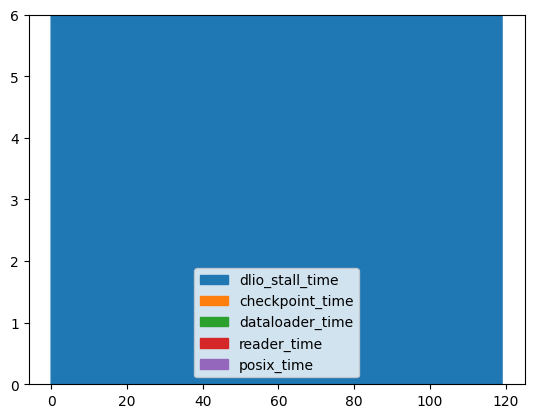

time: 239 ms (started: 2024-12-02 10:39:18 -08:00)


In [21]:
df3.query('compute_time > 0').sort_index()[
    # ['dlio_compute_time', 'dlio_stall_time', 'posix_time']
    [
        # 'compute_time',
        # 'dlio_compute_time',
        'dlio_stall_time',
        'checkpoint_time',
        'dataloader_time',
        'reader_time',
        # 'dataloader_sample_time',
        'posix_time',
    ]
].plot(kind='area', ylim=(0, 6))

<Axes: >

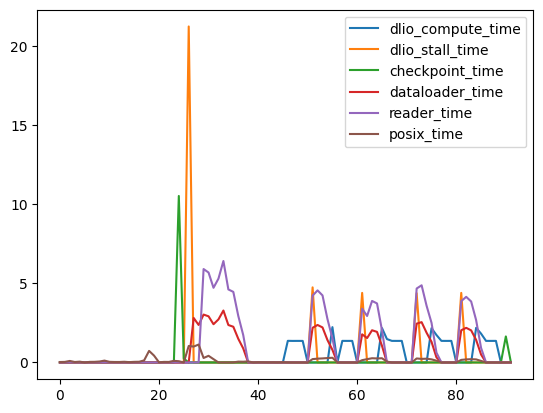

time: 346 ms (started: 2024-12-02 10:32:04 -08:00)


In [16]:
pd.read_csv('unet3d_node1_time_range.csv').sort_index()[
    # ['dlio_compute_time', 'dlio_stall_time', 'posix_time']
    [
        # 'compute_time',
        'dlio_compute_time',
        'dlio_stall_time',
        'checkpoint_time',
        'dataloader_time',
        'reader_time',
        # 'dataloader_sample_time',
        'posix_time',
    ]
].plot()

* image reuse / prefetching distance 
* iter = batch of images = whether `image_idx` was seen before
* image is ready or not (at every stall time)
* additional = how frequently an image gets stalled!!
* only for pytorch

* what metrics are most useful for each use cases
* think about visualization
* check bottleneck detection

* intro
* new metrics for ai workloads 
* and ai workloads need multiple of these
* for each use case, show workload characteristics
* design (method = 2 pages)
* how to combine metrics 
* evaluation
* each app > character > key metrics > bottleneck detection

<Axes: >

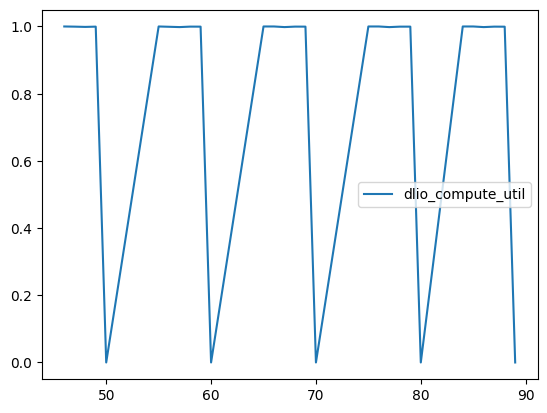

time: 188 ms (started: 2024-12-02 10:44:08 -08:00)


In [22]:
pd.read_csv('unet3d_node1_time_range.csv').query('compute_time > 0').sort_index()[
    # ['dlio_compute_time', 'dlio_stall_time', 'posix_time']
    [
        # 'compute_time',
        'dlio_compute_util',
        # 'checkpoint_time',
        # 'dataloader_time',
        # 'reader_time',
        # 'dataloader_sample_time',
        # 'posix_time',
    ]
].plot()

In [7]:
output.handle_result(metrics=cfg.metrics, result=result)

╭────────────────────────────────────────────── I/O Characteristics ──────────────────────────────────────────────╮
│                                                                                                                 │
│  Runtime          145.67 seconds                                                                                │
│  I/O Time         3.22 seconds                                                                                  │
│                   ├── Read - 2.45 seconds (76.01%)                                                              │
│                   ├── Write - 0.00 seconds (0.04%)                                                              │
│                   └── Metadata - 2.17 seconds (67.31%)                                                          │
│  I/O Operations   1,101,599 ops                                                                                 │
│                   ├── Read - 43,368 ops (3.94%)                                                                 │
│                   ├── Write - 300 ops (0.03%)                                                                   │
│                   └── Metadata - 1,055,563 ops (95.82%)                                                         │
│  I/O Size         92.50 GiB                                                                                     │
│                   ├── Read - 92.50 GiB (100.00%)                                                                │
│                   └── Write - 20.39 kiB (0.00%)                                                                 │
│  Read Requests    4 kiB-4 MiB - 43,336 ops                                                                      │
│                   ├── <4 kiB - 11,927 ops (27.52%)                                                              │
│                   ├── 4-16 kiB - 2,145 ops (4.95%)                                                              │
│                   ├── 16-64 kiB - 2,704 ops (6.24%)                                                             │
│                   ├── 256 kiB-1 MiB - 4 ops (0.01%)                                                             │
│                   └── 1-4 MiB - 26,556 ops (61.28%)                                                             │
│  Write Requests   4 kiB-4 kiB - 300 ops                                                                         │
│                   └── <4 kiB - 300 ops (100.00%)                                                                │
│  Nodes            1 node                                                                                        │
│  Apps             1 app                                                                                         │
│  Processes/Ranks  96 processes                                                                                  │
│  Files            6,073 files                                                                                   │
│                   ├── Shared: 5,464 files (89.97%)                                                              │
│                   └── FPP: 609 files (10.03%)                                                                   │
│  Time Periods     68 time periods (Time Granularity: 1,000,000.0)                                               │
│  Access Pattern   Sequential: 43,668 ops (100.00%) - Random: 0 ops (0.00%)                                      │
│                                                                                                                 │
╰─ R: Read - W: Write - M: Metadata  ─────────────────────────────────────────────────────────────────────────────╯
                                                                                                                   
╭────────────────────────────────── I/O Time: 5 I/O Bottlenecks with 15 Reasons ──────────────────────────────────╮
│                                                       

time: 1.99 s (started: 2024-10-14 11:01:54 -07:00)
